In [1]:
import eos
import numpy as np

# Theory Predictions and their Uncertainties

## Listing the built-in Observables

In [2]:
eos.Observables(prefix='D', name='BR')

In [3]:
eos.Observables()['B->Dlnu::BR']

## Constructing and Evaluating an Observable

In [4]:
parameters = eos.Parameters.Defaults()
kinematics = eos.Kinematics(q2_min=0.02, q2_max=11.60)
obs = eos.Observable.make('B->Dlnu::BR', parameters, kinematics, eos.Options())
display(obs)

B->Dlnu::BR,(eos.Observable)
current value,0.023


In [5]:
kinematics = eos.Kinematics(q2_min=3.17, q2_max=11.60)
obs = eos.Observable.make('B->Dlnu::BR', parameters, kinematics, eos.Options(l='tau'))
display(obs)

B->Dlnu::BR,(eos.Observable)
current value,0.006886


INFO:root:   plotting EOS observable "B->Dlnu::dBR/dq2;l=mu"
INFO:root:   plotting EOS observable "B->Dlnu::dBR/dq2;l=tau"


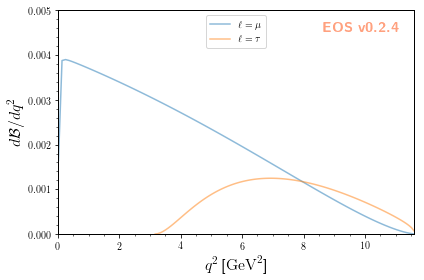

In [6]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.60] },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3] },
        'legend': { 'location': 'upper center' }
    },
    'contents': [
        {
            'label': r'$\ell=\mu$',
            'type': 'observable',
            'observable': 'B->Dlnu::dBR/dq2;l=mu',
            'kinematic': 'q2',
            'range': [0.02, 11.60],
        },
        {
            'label': r'$\ell=\tau$',
            'type': 'observable',
            'observable': 'B->Dlnu::dBR/dq2;l=tau',
            'kinematic': 'q2',
            'range': [3.17, 11.60],
        }
    ]
}
eos.plot.Plotter(plot_args).plot()

## Estimating Theory Uncertainties

In [7]:
analysis_args = {
    'global_options': None,
    'priors': [
        { 'parameter': 'B->D::alpha^f+_0@BSZ2015', 'min':  0.0, 'max':  1.0 },
        { 'parameter': 'B->D::alpha^f+_1@BSZ2015', 'min': -5.0, 'max': +5.0 },
        { 'parameter': 'B->D::alpha^f+_2@BSZ2015', 'min': -5.0, 'max': +5.0 },
        { 'parameter': 'B->D::alpha^f0_1@BSZ2015', 'min': -5.0, 'max': +5.0 },
        { 'parameter': 'B->D::alpha^f0_2@BSZ2015', 'min': -5.0, 'max': +5.0 }
    ],
    'likelihood': [
        'B->D::f_++f_0@HPQCD2015A',
        'B->D::f_++f_0@FNALMILC2015A'
    ]
}
analysis = eos.Analysis(**analysis_args)
obs_mu  = eos.Observable.make(
    'B->Dlnu::BR',
    analysis.parameters,
    eos.Kinematics(q2_min=0.02, q2_max=11.60),
    eos.Options(**{'l':'mu', 'form-factors':'BSZ2015'})
)
obs_tau = eos.Observable.make(
    'B->Dlnu::BR',
    analysis.parameters,
    eos.Kinematics(q2_min=3.17, q2_max=11.60),
    eos.Options(**{'l':'tau','form-factors':'BSZ2015'})
)
obs_R_D = eos.Observable.make(
    'B->Dlnu::R_D',
    analysis.parameters,
    eos.Kinematics(q2_mu_min=0.02, q2_mu_max=11.60, q2_tau_min=3.17, q2_tau_max=11.60),
    eos.Options(**{'form-factors':'BSZ2015'})
)
observables=(obs_mu, obs_tau, obs_R_D)

In [8]:
parameter_samples, log_weights, observable_samples = analysis.sample(N=5000, pre_N=1000, observables=observables)

INFO:root:Prerun 0 out of 3
INFO:root:Prerun 0: acceptance rate is   2%
INFO:root:Prerun 1 out of 3
INFO:root:Prerun 1: acceptance rate is   4%
INFO:root:Prerun 2 out of 3
INFO:root:Prerun 2: acceptance rate is  10%
INFO:root:Main run: started ...
INFO:root:Main run: acceptance rate is  30%


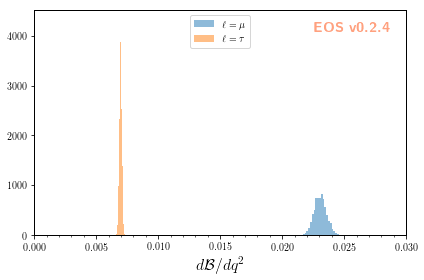

In [9]:
plot_args = {
    'plot': {
        'x': { 'label': r'$d\mathcal{B}/dq^2$',  'range': [0.0,  3e-2] },
        'legend': { 'location': 'upper center' }
    },
    'contents': [
        { 'label': r'$\ell=\mu$', 'type': 'histogram', 'bins': 30, 'data': { 'samples': observable_samples[:, 0], 'log_weights': log_weights }},
        { 'label': r'$\ell=\tau$','type': 'histogram', 'bins': 30, 'data': { 'samples': observable_samples[:, 1], 'log_weights': log_weights }},
    ]
}
eos.plot.Plotter(plot_args).plot()

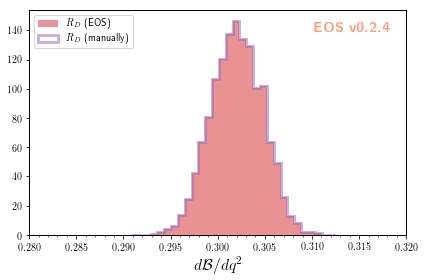

In [10]:
plot_args = {
    'plot': {
        'x': { 'label': r'$d\mathcal{B}/dq^2$',  'range': [0.28,  0.32] },
        'legend': { 'location': 'upper left' }
    },
    'contents': [
        { 'label': r'$R_D$ (EOS)',     'type': 'histogram', 'bins': 30, 'color': 'C3', 'data': { 'samples': observable_samples[:, 2], 'log_weights': log_weights }},
        { 'label': r'$R_D$ (manually)','type': 'histogram', 'bins': 30, 'color': 'C4', 'data': { 'samples': [o[1] / o[0] for o in observable_samples[:]], 'log_weights': log_weights },
          'histtype': 'step'},
    ]
}
eos.plot.Plotter(plot_args).plot()

In [11]:
print('{obs};{opt}  = {mean:.4f} +/- {std:.4f}'.format(
    obs=obs_mu.name(), opt=obs_mu.options(),
    mean=np.average(observable_samples[:,0], weights=np.exp(log_weights)),
    std=np.sqrt(np.var(observable_samples[:, 0]))
))
print('{obs};{opt} = {mean:.4f} +/- {std:.4f}'.format(
    obs=obs_tau.name(), opt=obs_tau.options(),
    mean=np.average(observable_samples[:,1], weights=np.exp(log_weights)),
    std=np.sqrt(np.var(observable_samples[:, 1]))
))
print('{obs};{opt}      = {mean:.4f} +/- {std:.4f}'.format(
    obs=obs_R_D.name(), opt=obs_R_D.options(),
    mean=np.average(observable_samples[:,2], weights=np.exp(log_weights)),
    std=np.sqrt(np.var(observable_samples[:, 1]))
))

B->Dlnu::BR;form-factors=BSZ2015,l=mu  = 0.0231 +/- 0.0007
B->Dlnu::BR;form-factors=BSZ2015,l=tau = 0.0070 +/- 0.0001
B->Dlnu::R_D;form-factors=BSZ2015      = 0.3020 +/- 0.0001


In [12]:
mu_q2values  = np.unique(np.concatenate((np.linspace(0.02,  1.00, 20), np.linspace(1.00, 11.60, 20))))
mu_obs       = [eos.Observable.make(
                   'B->Dlnu::dBR/dq2', analysis.parameters, eos.Kinematics(q2=q2),
                   eos.Options(**{'form-factors': 'BSZ2015', 'l': 'mu'}))
               for q2 in mu_q2values]
tau_q2values = np.linspace(3.17, 11.60, 40)
tau_obs      = [eos.Observable.make(
                   'B->Dlnu::dBR/dq2', analysis.parameters, eos.Kinematics(q2=q2),
                   eos.Options(**{'form-factors': 'BSZ2015', 'l': 'tau'}))
               for q2 in tau_q2values]

_, log_weights, mu_samples  = analysis.sample(N=5000, pre_N=1000, observables=mu_obs)
_, log_weights, tau_samples = analysis.sample(N=5000, pre_N=1000, observables=tau_obs)

INFO:root:Prerun 0 out of 3
INFO:root:Prerun 0: acceptance rate is   2%
INFO:root:Prerun 1 out of 3
INFO:root:Prerun 1: acceptance rate is   1%
INFO:root:Prerun 2 out of 3
INFO:root:Prerun 2: acceptance rate is   6%
INFO:root:Main run: started ...
INFO:root:Main run: acceptance rate is  16%
INFO:root:Prerun 0 out of 3
INFO:root:Prerun 0: acceptance rate is   1%
INFO:root:Prerun 1 out of 3
INFO:root:Prerun 1: acceptance rate is   2%
INFO:root:Prerun 2 out of 3
INFO:root:Prerun 2: acceptance rate is  10%
INFO:root:Main run: started ...
INFO:root:Main run: acceptance rate is  20%


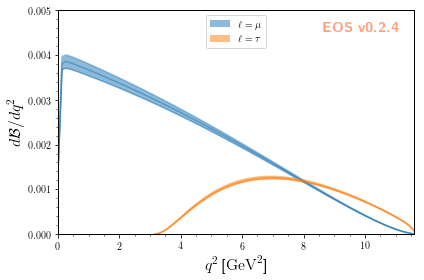

In [13]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.60] },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3] },
        'legend': { 'location': 'upper center' }
    },
    'contents': [
        {
          'label': r'$\ell=\mu$', 'type': 'uncertainty', 'range': [0.02, 11.60],
          'data': { 'samples': mu_samples, 'xvalues': mu_q2values }
        },
        {
          'label': r'$\ell=\tau$','type': 'uncertainty', 'range': [3.17, 11.60],
          'data': { 'samples': tau_samples, 'xvalues': tau_q2values }
        },
    ]
}
eos.plot.Plotter(plot_args).plot()